# Tabular Weather Prediction Tutorial

This tutorial steps through the uncertainty challenge on tabular weather data for regression. 

## Outline

1. Repository download
2. Data download
3. Data loading
4. Training & Saving
5. Model loading
6. Evaluation & Inference
7. Submission

## 1. Repository Download

The Github repository with useful scripts is at: [repo](https://github.com/yandex-research/shifts.git)

In [ ]:
# Clone the repository
! git clone https://github.com/yandex-research/shifts

In [53]:
# Add to path
import sys
sys.path.append('../shifts/weather/')

## 2. Data Download

Data is stored at: [data](https://storage.yandexcloud.net/yandex-research/shifts/weather/canonical-trn-dev-data.tar)

In [ ]:
# Download the data. Note, by downloading the data you agree to it's CC BY SA NC 4.0 license!
! wget https://storage.yandexcloud.net/yandex-research/shifts/weather/canonical-trn-dev-data.tar

## 3. Data Loading

All data is provided as csv files. You should have downloaded the following data files:

- `train.csv`
- `dev_in.csv`
- `dev_out.csv`

`dev_in` consists of data in-domain with `train` in terms of time and climate. `dev_out` consists of data shifted in time and climates with respect to `train`.

This tutorial will assume that all data files are placed in a local directory named `./data/`. 

In [1]:
import pandas as pd

# Load each data file as a pandas data frame
df_train = pd.read_csv('data/train.csv')
df_train.head()

,fact_time,fact_latitude,fact_longitude,fact_temperature,fact_cwsm_class,climate,topography_bathymetry,sun_elevation,climate_temperature,climate_pressure,...,cmc_0_1_66_0_grad,cmc_0_1_66_0_next,cmc_0_1_67_0_grad,cmc_0_1_67_0_next,cmc_0_1_68_0_grad,cmc_0_1_68_0_next,gfs_2m_dewpoint_grad,gfs_2m_dewpoint_next,gfs_total_clouds_cover_low_grad,gfs_total_clouds_cover_low_next
0,1.543321e+09,26.968800,-99.248901,2.0,0.0,dry,127.0,-17.526443,14.613571,754.263405,...,0.0,0.0,0.0,0.0,0.0,0.0,-2.600006,-2.750006,0.0,0.0
1,1.538776e+09,29.374201,-100.927002,31.0,20.0,mild temperate,297.0,41.531032,26.992143,733.117168,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.600006,17.950006,-12.0,11.0
2,1.552115e+09,22.149599,113.592003,17.0,10.0,mild temperate,-1.0,43.916531,18.842143,761.571076,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.233978,21.450006,1.0,8.0
3,1.549566e+09,34.678699,-86.684799,24.0,20.0,mild temperate,193.0,40.240955,8.303571,747.524910,...,0.0,0.0,0.0,0.0,0.0,0.0,0.059448,16.150018,-58.0,41.0
4,1.552910e+09,46.066667,41.966667,9.0,20.0,dry,90.0,30.394660,6.451429,753.168113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.400024,3.150018,18.0,92.0


In [2]:
df_dev_in = pd.read_csv('data/dev_in.csv')
df_dev_out = pd.read_csv('data/dev_out.csv')

In [3]:
# Visualize the temperature range in the data

from visualize import visualize_temperatures
df_names = ['train', 'dev_in', 'dev_out']
df_list = [df_train, df_dev_in, df_dev_out]

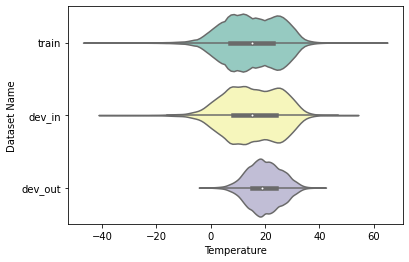

<Figure size 432x288 with 0 Axes>

In [4]:
# Violin Plot
visualize_temperatures(df_list, df_names, plot_type='violin')

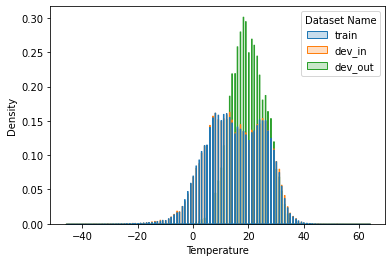

<Figure size 432x288 with 0 Axes>

In [5]:
# Histogram
visualize_temperatures(df_list, df_names, plot_type='histogram')

## 4. Training and Saving

### Training

In this tutorial, the `CatBoostRegressor` is used as the model.
- An ensemble of models are trained.
- It is important to use `RMSEWithUncertainty` as the loss function during training time in order to be able to calculate uncertainty measures during inference.
- The models are trained using `df_train` and the hyperparameters should be finetuned using `df_dev_in`.

In [6]:
# Extract features and targets, and remove redundant meta-data
X_train = df_train.iloc[:,6:]
X_dev_in = df_dev_in.iloc[:,6:]
y_train = df_train['fact_temperature']
y_dev_in = df_dev_in['fact_temperature']

In [7]:
# Set training hyperparameters (note these are dummy hyperparameters - you will need to select your own)
ensemble_size = 3
depth = 2
iterations = 200
learning_rate = 0.03

In [8]:
# Train ensemble of models

import catboost

trained_models = []
for seed in range(ensemble_size):
    
    model = catboost.CatBoostRegressor(
        learning_rate = learning_rate,
        iterations = iterations,
        depth = depth,
        loss_function = 'RMSEWithUncertainty',
        eval_metric = 'RMSE',
        random_seed = seed)
    
    print(f'\n Model index: {seed}\n')
    
    model.fit(
        X_train,
        y_train,
        verbose = 100,
        eval_set = (X_dev_in, y_dev_in))
    
    trained_models.append(model)


 Model index: 0

0:	learn: 10.0772485	test: 10.0762054	best: 10.0762054 (0)	total: 3.48s	remaining: 11m 32s
100:	learn: 2.8933962	test: 2.8692723	best: 2.8692723 (100)	total: 1m 45s	remaining: 1m 43s
199:	learn: 2.4636227	test: 2.4470545	best: 2.4470545 (199)	total: 3m 2s	remaining: 0us

bestTest = 2.447054531
bestIteration = 199


 Model index: 1

0:	learn: 10.0797424	test: 10.0788222	best: 10.0788222 (0)	total: 1.12s	remaining: 3m 43s
100:	learn: 2.8958509	test: 2.8717422	best: 2.8717422 (100)	total: 1m 29s	remaining: 1m 27s
199:	learn: 2.4668849	test: 2.4504754	best: 2.4504754 (199)	total: 2m 58s	remaining: 0us

bestTest = 2.450475398
bestIteration = 199


 Model index: 2

0:	learn: 10.0766372	test: 10.0755385	best: 10.0755385 (0)	total: 1.29s	remaining: 4m 16s
100:	learn: 2.8947113	test: 2.8704513	best: 2.8704513 (100)	total: 1m 54s	remaining: 1m 52s
199:	learn: 2.4646485	test: 2.4479654	best: 2.4479654 (199)	total: 3m 30s	remaining: 0us

bestTest = 2.447965358
bestIteration = 199

### Saving

The trained models are saved below into the current directory. The directory path can be changed to save the models in any preferred location.

In [9]:
dir_path = '.'
for i, model in enumerate(trained_models):
    model.save_model(f'{dir_path}/model{i+1}.cbm')

## 5. Model Loading

### Loading Trained Models

This section assumes that the trained models have been saved in the current directory. The directory path can be altered to point to any location with the trained models.

In [10]:
dir_path = '.'
trained_models = []

# 3 models trained above in this tutorial
ensemble_size=3

for ind in range(1, ensemble_size+1):
    model = catboost.CatBoostRegressor()
    model.load_model(f'{dir_path}/model{ind}.cbm')
    trained_models.append(model)

### Loading Baseline Models

The next section of code will show how to load existing, provided baseline trained models

The first step is to ensure that the baseline models have been downloaded and saved in some directory.
The trained baseline models are provided at: [baseline models](https://storage.yandexcloud.net/yandex-research/shifts/weather/baseline-models.tar)

Then, the models can be loaded as follows...

In [ ]:
# Download baselines
! wget https://storage.yandexcloud.net/yandex-research/shifts/weather/baseline-models.tar

In [11]:
# Loading Trained Baseline Models
# Assume models saved as dir_path/seedi.cbm

dir_path = './baseline-models'
baseline_models = []

# 10 models provided
ensemble_size=10

for ind in range(1, ensemble_size+1):
    model = catboost.CatBoostRegressor()
    model.load_model(f'{dir_path}/seed{ind}.cbm')
    baseline_models.append(model)

## 6. Evaluation and Inference

Evaluation and Inference here is shown for the `baseline_models`, but it can be performed in exactly the same manner for the `trained_models`.

All evaluation and inference in this section is carried out on a combined dataset of `dev_in` + `dev_out` = `dev`.
The objective here is two fold:

1. Evaluate the ensemble of trained models to get predictions for each data point
2. Use the predictions to determine an uncertainty score for each data point using any chosen uncertainty measure

It is hoped that the uncertainty measure chosen ensures that data points with greater errors yield greater uncertainties. The uncertainty scores are used to generate retention curves (lowest x% of uncertainties are kept). 

In [12]:
# Create a combined evaluation dataset and keep only the features
df_dev = pd.concat([df_dev_in, df_dev_out])
X_dev = df_dev.iloc[:,6:]

In [13]:
# Get ensemble of predictions for each data point

import numpy as np

def get_predictions(features_df, model):
    '''
    Calculates predictions on df features for specified model
    
    Return: array [num_samples x 2],
        where
            num_samples = number of rows in features_df
            2 = [mean, variance]
    
    '''
    return model.predict(features_df)


def get_all_predictions(features_df, models_list):
    '''
    Return: array [ensemble_size x num_samples x 2],
        where
            ensemble_size = number of models in models_list
            num_samples = number of rows in features_df
            2 = [mean, variance]
    '''
    all_preds = []
    for model in models_list:
        preds = np.asarray(get_predictions(features_df, model))
        all_preds.append(preds)
    return np.stack(all_preds, axis=0)


all_preds = get_all_predictions(X_dev, baseline_models)

In [14]:
# Choose any uncertainty measure to calculate uncertainty scores
# This tutorial uses total variance as the uncertainty measure

from uncertainty import ensemble_uncertainties_regression

all_uncertainty = ensemble_uncertainties_regression(all_preds)
uncertainties = all_uncertainty['tvar']

### Retention Curves

In this tutorial, retention curves are generated for two different metrics:
1. Mean Squared Error (MSE)
2. F1-score

In each case, the x-axis represents the fraction of data points retained, where the data points are ordered by the chosen uncertainty measure.

In [15]:
# Get ensemble predictions
all_preds_mean = all_preds[:,:,0]
avg_preds = np.squeeze(np.mean(all_preds_mean, axis=0))

# Get target values
targets = np.asarray(df_dev['fact_temperature'])

# squared error
errors = (avg_preds - targets) ** 2

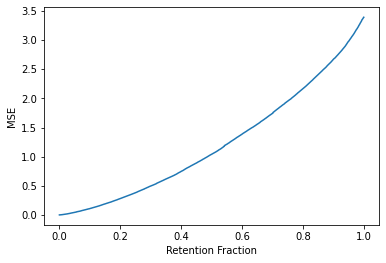

<Figure size 432x288 with 0 Axes>

In [16]:
# MSE retention curve
from assessment import calc_uncertainty_regection_curve
import matplotlib.pyplot as plt

# MSE retention values
rejection_mse = calc_uncertainty_regection_curve(errors, uncertainties)
retention_mse = rejection_mse[::-1]

retention_fractions = np.linspace(0,1,len(retention_mse))

# plot
plt.plot(retention_fractions, retention_mse)
plt.ylabel('MSE')
plt.xlabel("Retention Fraction")
plt.show()
plt.clf()

F1 score at 95% retention:  0.6583114832320486


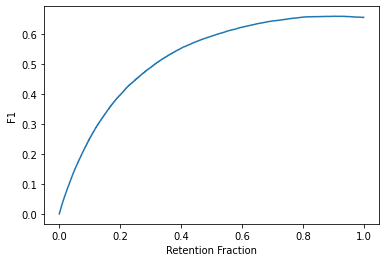

<Figure size 432x288 with 0 Axes>

In [17]:
# F1-score retention curve
from assessment import f_beta_metrics

# Use an acceptable error threshold of 1 degree
thresh = 1.0

# Get all metrics
f_auc, f95, retention_f1 = f_beta_metrics(errors, uncertainties, thresh, beta=1.0)
print("F1 score at 95% retention: ", f95)

retention_fractions = np.linspace(0,1,len(retention_f1))

# plot
plt.plot(retention_fractions, retention_f1)
plt.ylabel('F1')
plt.xlabel("Retention Fraction")
plt.show()
plt.clf()

## 7. Submission

A zipped csv file in a specific format has to be prepared for submission. It is important that the submission is for the combined dataset of `dev_in` + `dev_out` = `dev`, where order of concatenation is as stated - this is to ensure all given IDs are correct at submission time.

The submitted csv file should contain the following columns:
- ID
- PRED
- UNCERTAINTY

In [18]:
# Prepare the ids
ids = np.arange(1, len(df_dev) + 1)

# Predictions are the mean predictions across the ensemble of models
preds = np.mean(all_preds[:,:,0], axis=0)

# The uncertainties have been calculated in the previous step

# Store all the information to be submitted in a df
df_submission = pd.DataFrame(data={
        'ID' : ids,
        'PRED' : preds,
        'UNCERTAINTY' : uncertainties
        })

df_submission.head()

,ID,PRED,UNCERTAINTY
0,1,10.109489,0.969647
1,2,3.986508,0.913031
2,3,25.420558,0.984064
3,4,4.282185,0.830858
4,5,14.192034,1.829973


In [19]:
# Save as csv
out_file = 'df_submission.csv'
df_submission.to_csv(out_file, index=False)

In [ ]:
# tar the csv file
! tar -zcvf df_submission.tar.gz df_submission.csv

Finally, submit the submission file to the [website](https://research.yandex.com/shifts/weather).